In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import lime
from lime import lime_tabular
import shap
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import warnings
warnings.filterwarnings("ignore")

2025-05-03 20:41:06.565940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746304866.790338      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746304866.858961      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***Loading and EDA***

In [3]:
# Define paths and parameters
data_dir = "/kaggle/input/brain-tumor-mri-dataset/"
train_path = os.path.join(data_dir, "Training")
test_path = os.path.join(data_dir, "Testing")
img_size = (224, 224)
batch_size = 16  # Small batch size to reduce memory usage
num_classes = 4

# Load all images and labels into memory
all_images = []
all_labels = []
class_names = sorted(os.listdir(train_path))  # ['glioma', 'meningioma', 'notumor', 'pituitary']
print("Loading images...")
for class_idx, class_name in enumerate(class_names):
    train_class_path = os.path.join(train_path, class_name)
    for img_name in os.listdir(train_class_path):
        img_path = os.path.join(train_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        all_images.append(img_array)
        all_labels.append(class_idx)
    test_class_path = os.path.join(test_path, class_name)
    for img_name in os.listdir(test_class_path):
        img_path = os.path.join(test_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        all_images.append(img_array)
        all_labels.append(class_idx)

# Convert to NumPy arrays
all_images = np.array(all_images, dtype='float16')  # Shape: (7023, 224, 224, 3)
all_labels = np.array(all_labels)  # Shape: (7023,)
print(f"Loaded {all_images.shape[0]} images with shape {all_images.shape[1:]}")

Loading images...
Loaded 7023 images with shape (224, 224, 3)


Training Class Counts: {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}
Testing Class Counts: {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


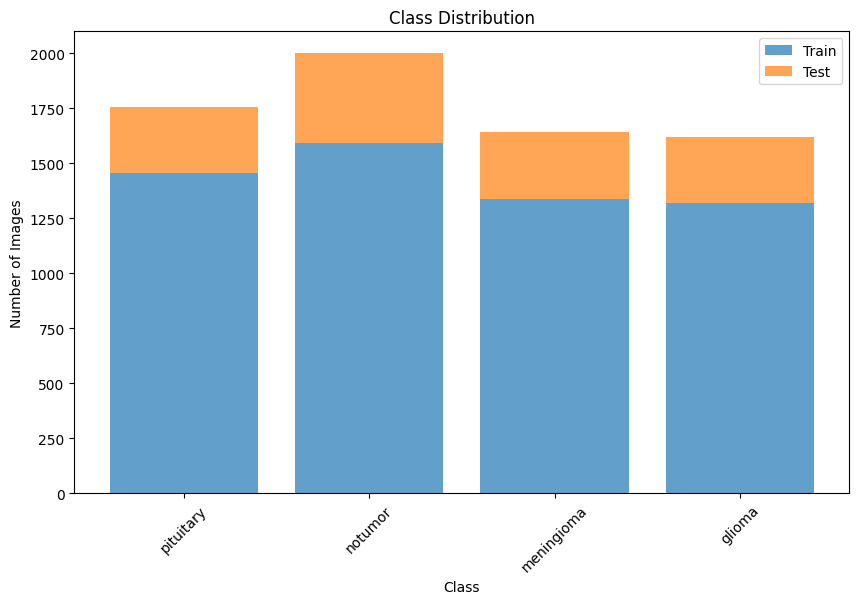

In [4]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)
print("Training Class Counts:", train_counts)
print("Testing Class Counts:", test_counts)

# Plot class distribution
class_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Count'])
class_df = class_df.merge(pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test Count']), on='Class')
class_df['Total Count'] = class_df['Train Count'] + class_df['Test Count']
plt.figure(figsize=(10, 6))
plt.bar(class_df['Class'], class_df['Train Count'], label='Train', alpha=0.7)
plt.bar(class_df['Class'], class_df['Test Count'], bottom=class_df['Train Count'], label='Test', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [5]:
# Perform train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Training set: 4916 images
Validation set: 1053 images
Test set: 1054 images


In [6]:
from PIL import Image
import numpy as np

# Function to analyze image properties
def analyze_image_properties(directory, sample_size=50):
    dimensions = []
    file_sizes = []
    formats = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:sample_size]  # Sample to save time
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)  # (width, height)
                        formats.append(img.format)
                    file_sizes.append(os.path.getsize(img_path) / 1024)  # Size in KB
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return dimensions, file_sizes, formats

# Analyze training set
train_dims, train_sizes, train_formats = analyze_image_properties(train_path)

Image Dimensions Summary:
             Width       Height
count   200.000000   200.000000
mean    474.390000   478.915000
std     137.149069   133.443334
min     173.000000   192.000000
25%     512.000000   512.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1365.000000  1365.000000

File Size Summary (KB):
count    200.000000
mean      25.343623
std       25.310409
min        4.333008
25%       16.021729
50%       21.182129
75%       26.421387
max      246.901367
dtype: float64

Image Formats:
JPEG    199
PNG       1
Name: count, dtype: int64


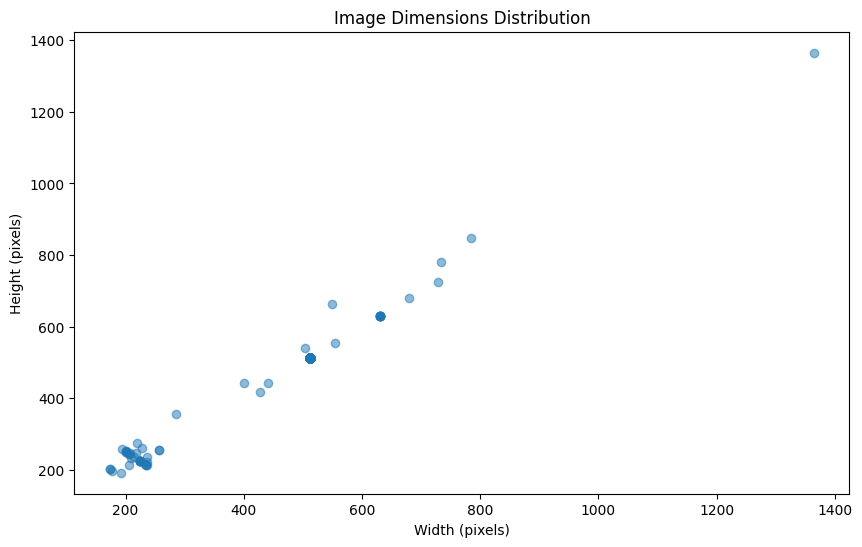

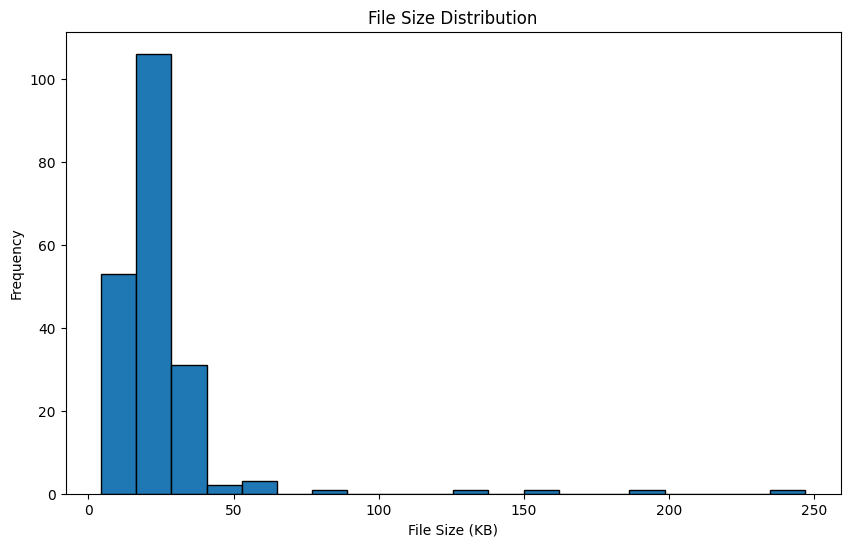

In [7]:
# Summary statistics
dims_df = pd.DataFrame(train_dims, columns=['Width', 'Height'])
print("Image Dimensions Summary:")
print(dims_df.describe())

print("\nFile Size Summary (KB):")
print(pd.Series(train_sizes).describe())

print("\nImage Formats:")
print(pd.Series(train_formats).value_counts())

# Plot dimensions
plt.figure(figsize=(10, 6))
plt.scatter(dims_df['Width'], dims_df['Height'], alpha=0.5)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimensions Distribution')
plt.show()

# Plot file sizes
plt.figure(figsize=(10, 6))
plt.hist(train_sizes, bins=20, edgecolor='black')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.title('File Size Distribution')
plt.show()

In [8]:
def check_data_quality(directory):
    corrupt_files = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image integrity
                except Exception as e:
                    corrupt_files.append(img_path)
                    print(f"Corrupt file detected: {img_path} - {e}")
    return corrupt_files

# Check training and testing sets
train_corrupt = check_data_quality(train_path)
test_corrupt = check_data_quality(test_path)
print(f"Corrupt files in training set: {len(train_corrupt)}")
print(f"Corrupt files in testing set: {len(test_corrupt)}")

Corrupt files in training set: 0
Corrupt files in testing set: 0


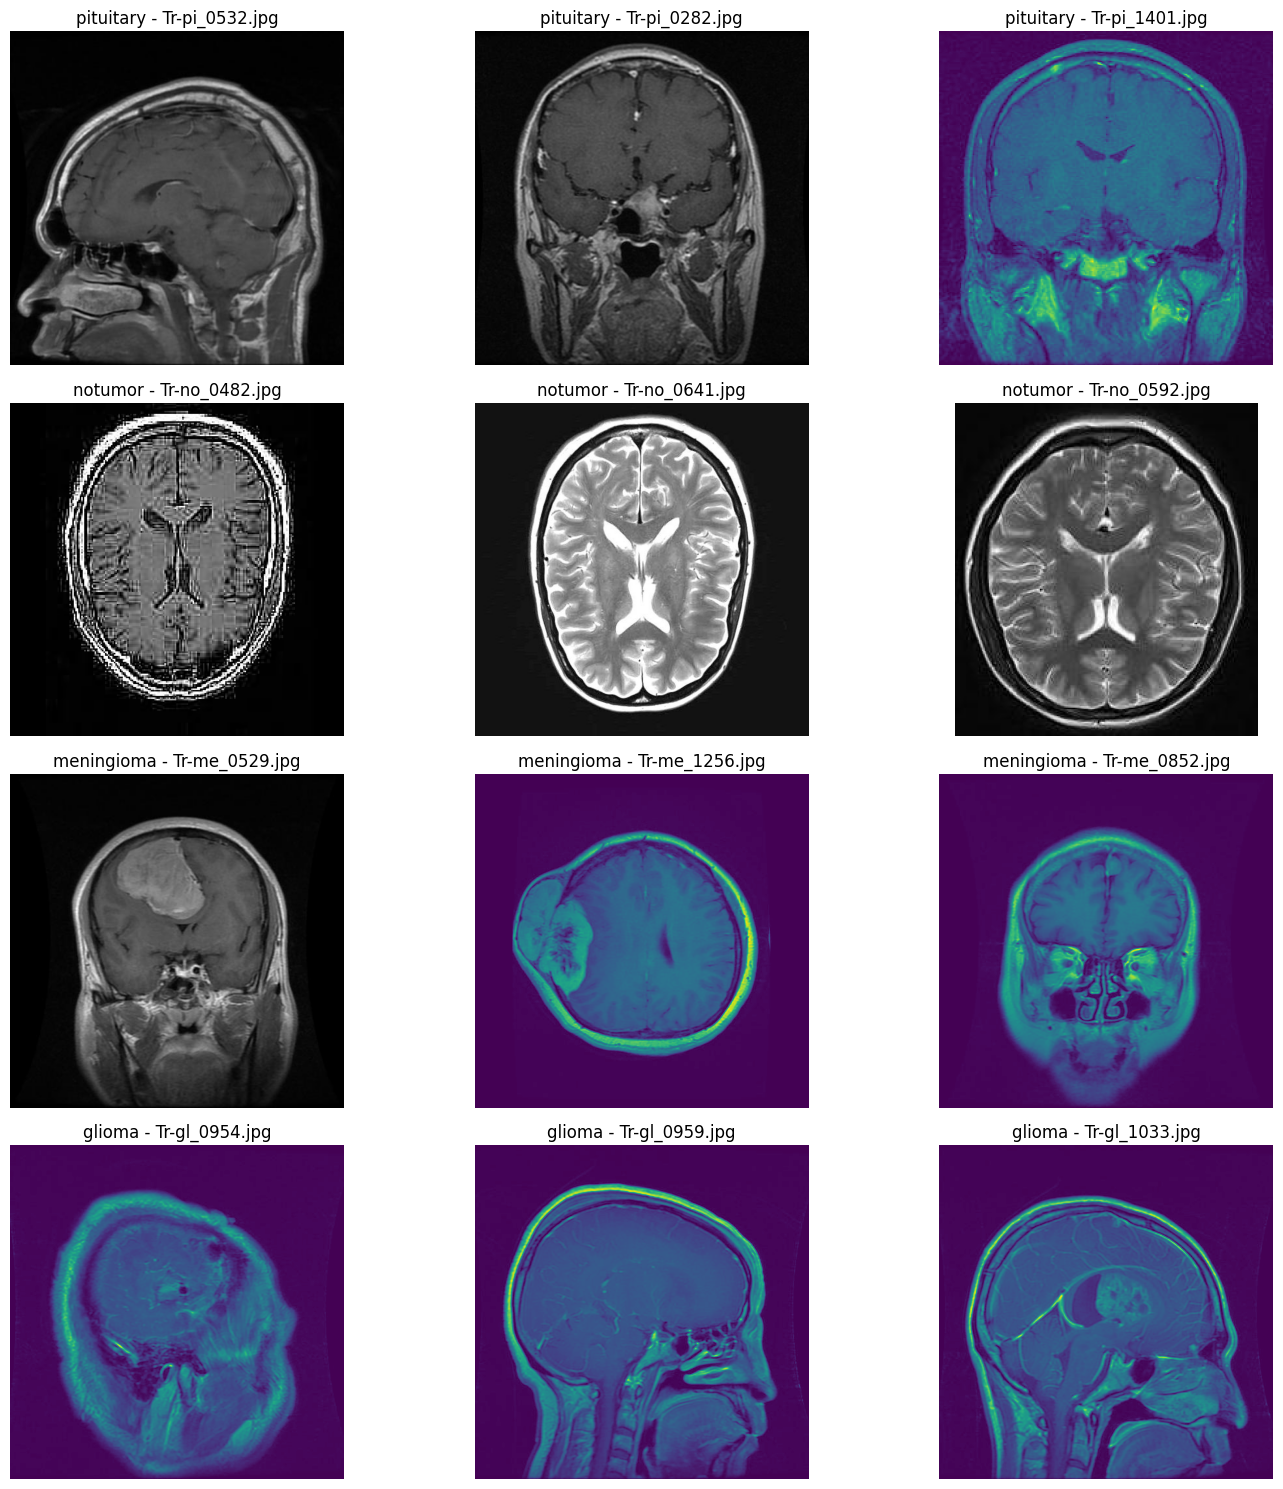

In [9]:
def plot_sample_images(directory, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    class_names = os.listdir(directory)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            img_files = os.listdir(class_path)[:num_samples]
            for j, img_name in enumerate(img_files):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
                        plt.imshow(img)
                        plt.title(f"{class_name} - {img_name}")
                        plt.axis('off')
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    plt.tight_layout()
    plt.show()

plot_sample_images(train_path)

In [17]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(96, (9, 9), strides=(4, 4), padding='valid', activation='relu')(input_layer)
x = BatchNormalization()(x)  # 5-channel normalization approximated with BatchNormalization
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # SoftMax pooling approximated with MaxPooling

x = Conv2D(256, (7, 7), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax', name='classification')(x)

In [ ]:
# Free memory
import gc
del all_images, all_labels
gc.collect()

In [15]:
gc.collect()

33711

In [18]:
cnn_model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
cnn_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [17]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=batch_size,
    callbacks=callbacks,

)

Epoch 1/50


I0000 00:00:1746294188.998574     102 service.cc:148] XLA service 0x7fb0f000c390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746294188.999152     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746294189.296030     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/308 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3504 - loss: 1.8005

I0000 00:00:1746294193.361810     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5304 - loss: 1.0842
Epoch 1: val_accuracy improved from -inf to 0.73979, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.5307 - loss: 1.0835 - val_accuracy: 0.7398 - val_loss: 0.7499 - learning_rate: 0.0010
Epoch 2/50
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7532 - loss: 0.6644
Epoch 2: val_accuracy improved from 0.73979 to 0.78443, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7533 - loss: 0.6640 - val_accuracy: 0.7844 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8122 - loss: 0.5097
Epoch 3: val_accuracy improved from 0.78443 to 0.81861, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8123 - loss: 0.5096 - val_accuracy: 0.8186 - val_loss: 0.5051 - learning_rate: 0.0010
Epoch 4/50
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accu

In [22]:
for layer in cnn_model.layers:
    print(layer.name)

input_layer_1
conv2d_5
batch_normalization_2
max_pooling2d_3
conv2d_6
batch_normalization_3
max_pooling2d_4
conv2d_7
conv2d_8
conv2d_9
max_pooling2d_5
flatten_1
dense_2
dropout_2
dense_3
dropout_3
classification


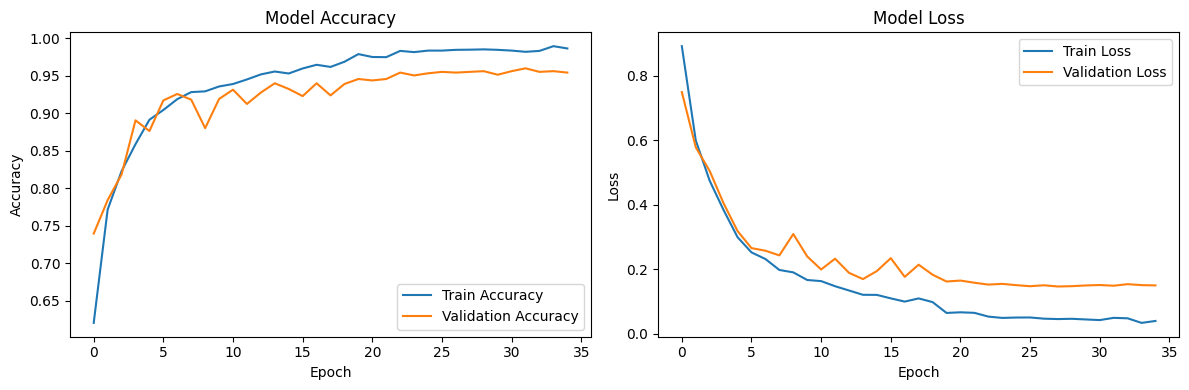

In [19]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Evaluate CNN on test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print("CNN Test Accuracy:", test_accuracy)
y_pred_cnn = cnn_model.predict(X_test, batch_size=8)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn_classes, target_names=class_names))

CNN Test Accuracy: 0.9430739879608154
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
CNN Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       243
  meningioma       0.87      0.91      0.89       247
     notumor       0.98      0.96      0.97       300
   pituitary       0.98      0.96      0.97       264

    accuracy                           0.94      1054
   macro avg       0.94      0.94      0.94      1054
weighted avg       0.94      0.94      0.94      1054



In [21]:
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)  # Extract features before last Dense

In [22]:
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [23]:
print("Extracted Feature Shape:", train_features.shape)  # (60000, num_features)

Extracted Feature Shape: (4916, 21632)


In [24]:
# Standardize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_features)
X_test_features = scaler.transform(test_features)

In [25]:
# Random Forest feature selection
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train_features, y_train)
selector = SelectFromModel(rf_feature_selector, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train_features)
X_test_selected = selector.transform(X_test_features)
print(f"Random Forest Reduced Shape: {X_train_selected.shape}")

# Free memory
del train_features, test_features, X_train_features, X_test_features
gc.collect()

Random Forest Reduced Shape: (4916, 10816)


9654

In [26]:
# Feature Selection Methods
methods = {
    'Random Forest': X_train_selected,
    'Decision Trees': None,
    'Z-score': None,
    'Random Forest Gini': None
}

In [27]:
# Decision Trees Feature Selection
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_selected, y_train)
dt_importances = dt.feature_importances_
dt_indices = np.argsort(dt_importances)[::-1][:1000]
methods['Decision Trees'] = X_train_selected[:, dt_indices]

In [28]:
# Z-score Feature Selection
z_scores = np.abs(zscore(X_train_selected, axis=0))
mean_z_scores = np.mean(z_scores, axis=0)
z_indices = np.argsort(mean_z_scores)[::-1][:1000]
methods['Z-score'] = X_train_selected[:, z_indices]

In [29]:
# Random Forest Gini Feature Selection
rf_gini = RandomForestClassifier(n_estimators=100, random_state=42)
rf_gini.fit(X_train_selected, y_train)
rf_gini_importances = rf_gini.feature_importances_
rf_gini_indices = np.argsort(rf_gini_importances)[::-1][:1000]
methods['Random Forest Gini'] = X_train_selected[:, rf_gini_indices]

In [30]:
results = {}
for method, X_train_method in methods.items():
    X_test_method = (X_test_selected[:, rf_gini_indices] if method == 'Random Forest Gini'
                     else X_test_selected[:, dt_indices] if method == 'Decision Trees'
                     else X_test_selected[:, z_indices] if method == 'Z-score'
                     else X_test_selected)
    svm = SVC(kernel='rbf', random_state=42, class_weight='balanced')
    svm.fit(X_train_method, y_train)
    y_pred = svm.predict(X_test_method)
    accuracy = accuracy_score(y_test, y_pred)
    results[method] = accuracy
    print(f"{method} SVM Accuracy: {accuracy:.4f}")

Random Forest SVM Accuracy: 0.9507
Decision Trees SVM Accuracy: 0.9383
Z-score SVM Accuracy: 0.9364
Random Forest Gini SVM Accuracy: 0.9383


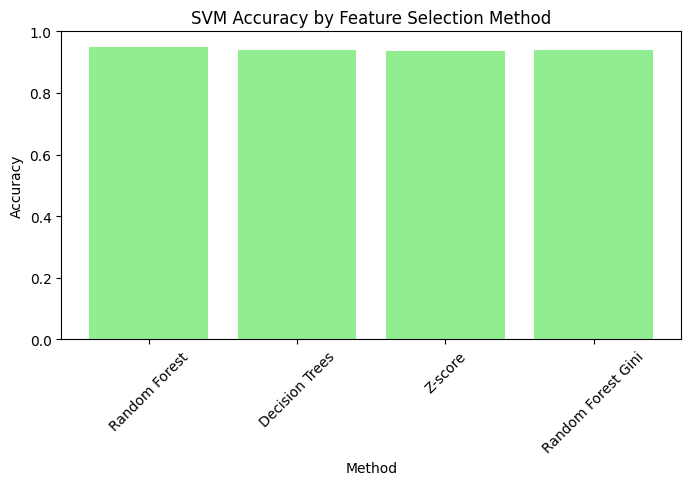

In [31]:
# Plot feature selection comparison
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color='lightgreen')
plt.title('SVM Accuracy by Feature Selection Method')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/feature_selection_comparison.png')
plt.show()
plt.close()


In [32]:
# Select the best method
best_method = max(results, key=results.get)
X_train_best = methods[best_method]
X_test_best = (X_test_selected[:, rf_gini_indices] if best_method == 'Random Forest Gini'
               else X_test_selected[:, dt_indices] if best_method == 'Decision Trees'
               else X_test_selected[:, z_indices] if best_method == 'Z-score'
               else X_test_selected)

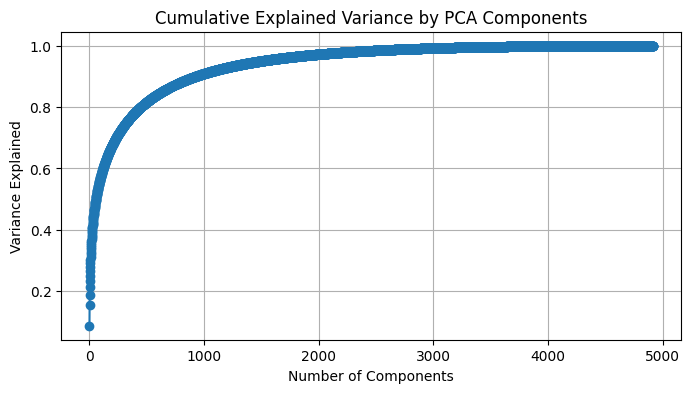

Optimal PCA components: 1495


In [63]:
# Determine optimal PCA components
pca = PCA()
pca.fit(X_train_best)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.grid()
plt.savefig('/kaggle/working/pca_elbow.png')
plt.show()
plt.close()

# Choose optimal components (e.g., where variance > 95%)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

# Apply PCA
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_best)
X_test_pca = pca.transform(X_test_best)


In [64]:
svm = SVC(C= 10 ,kernel='rbf', class_weight='balanced',probability  = True)

# Train and evaluate final SVM
svm.fit(X_train_pca, y_train)
y_pred_final = svm.predict(X_test_pca)
final_accuracy = accuracy_score(y_test, y_pred_final)
print("Final SVM Accuracy with Best Method + PCA:", final_accuracy)
print("Final SVM Classification Report:", classification_report(y_test, y_pred_final, target_names=class_names))

Final SVM Accuracy with Best Method + PCA: 0.9724857685009488
Final SVM Classification Report:               precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       243
  meningioma       0.93      0.97      0.95       247
     notumor       0.99      0.98      0.99       300
   pituitary       0.99      0.99      0.99       264

    accuracy                           0.97      1054
   macro avg       0.97      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054



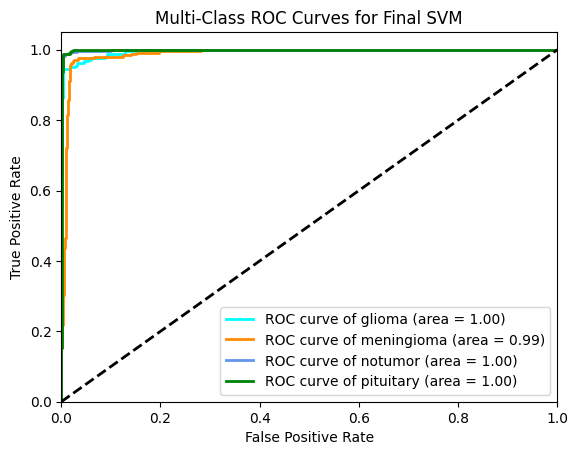

In [65]:
# AUC-ROC Curve for Final SVM
y_score = svm.decision_function(X_test_pca)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves for Final SVM')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/multi_class_roc_curves.png')
plt.show()
plt.close()

Area under the curve ranging between 0.99 and 1 for all classes indicating excellent performance.

In [66]:
import lime
from lime import lime_tabular
import shap

LIME Explanations for Selected Test Instances:

Explanation for test instance 0 (True label: glioma, Predicted: glioma)
PCA_23 <= -4.02: -0.1167
-9.75 < PCA_3 <= -1.62: 0.0580
PCA_2 <= -25.50: -0.0485
PCA_15 <= -5.46: -0.0481
PCA_46 > 3.34: 0.0391


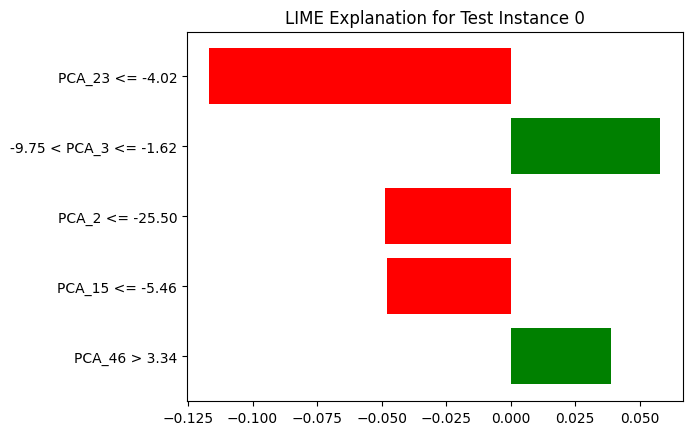


Explanation for test instance 1 (True label: meningioma, Predicted: meningioma)
PCA_3 <= -9.75: 0.2522
-11.10 < PCA_1 <= 10.17: 0.1298
PCA_23 > 4.70: 0.1073
PCA_12 <= -5.57: 0.0964
PCA_29 <= -4.15: -0.0810


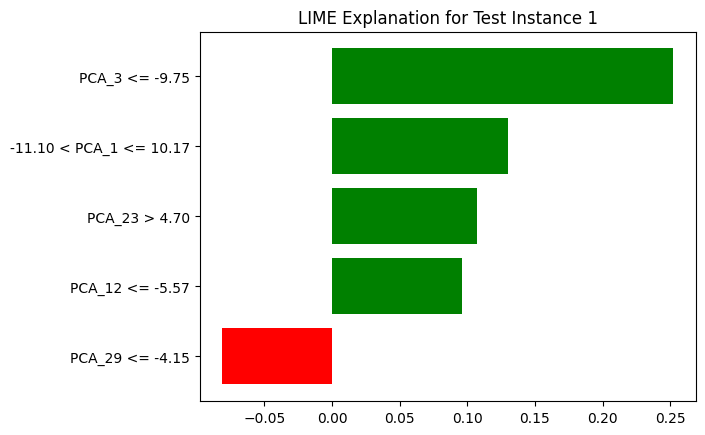


Explanation for test instance 2 (True label: notumor, Predicted: notumor)
PCA_3 <= -9.75: 0.2489
PCA_1 > 10.17: -0.1711
PCA_12 <= -5.57: 0.1048
PCA_15 <= -5.46: -0.0477
PCA_45 > 2.98: -0.0383


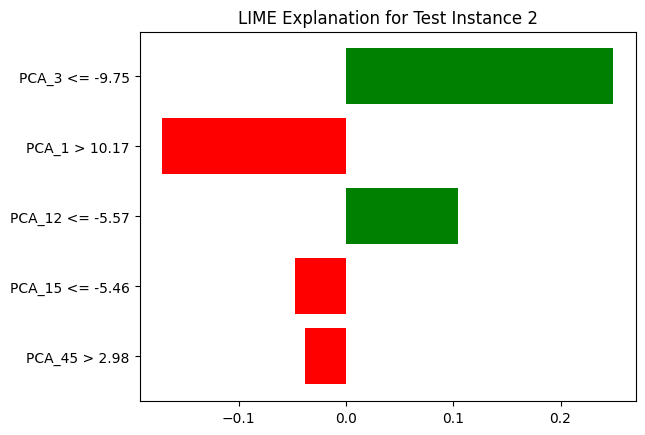

In [67]:
# LIME Explanations (Local Interpretability)
# Create feature names for PCA components
feature_names = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]

# Initialize LIME explainer for tabular data
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_pca,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    random_state=42
)

# Explain a few test instances (e.g., first 3 test samples)
print("LIME Explanations for Selected Test Instances:")
for idx in range(min(3, len(X_test_pca))):
    exp = lime_explainer.explain_instance(
        data_row=X_test_pca[idx],
        predict_fn=svm.predict_proba,
        num_features=5
    )
    print(f"\nExplanation for test instance {idx} (True label: {class_names[y_test[idx]]}, Predicted: {class_names[y_pred_final[idx]]})")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")
    # Plot the explanation
    exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Test Instance {idx}')
    plt.show()


### LIME Interpretations for SVM Predictions

#### Test Instance 0 (True: Glioma, Predicted: Glioma)
- **PCA_23 <= -4.02 (-0.1167)**: Low PCA_23 reduces glioma likelihood, suggesting higher values are more typical for glioma.
- **PCA_3 in [-9.75, -1.62] (0.0580)**: Moderate PCA_3 supports glioma prediction, capturing a key pattern.
- **PCA_2 <= -25.50 (-0.0485)**: Very low PCA_2 slightly opposes glioma, indicating higher PCA_2 may favor it.
- **PCA_15 <= -5.46 (-0.0481)**: Low PCA_15 reduces glioma likelihood, suggesting higher values align better.
- **PCA_46 > 3.34 (0.0391)**: High PCA_46 supports glioma, reflecting a specific feature.
- **Summary**: Moderate PCA_3 and high PCA_46 drive the correct glioma prediction, despite low PCA_23 and PCA_2 opposing.

#### Test Instance 1 (True: Meningioma, Predicted: Meningioma)
- **PCA_3 <= -9.75 (0.2522)**: Very low PCA_3 strongly favors meningioma, a dominant feature.
- **PCA_1 in [-11.10, 10.17] (0.1298)**: Moderate PCA_1 supports meningioma, aiding classification.
- **PCA_23 > 4.70 (0.1073)**: High PCA_23 supports meningioma, contrasting its role in glioma.
- **PCA_12 <= -5.57 (0.0964)**: Low PCA_12 reinforces meningioma prediction.
- **PCA_29 <= -4.15 (-0.0810)**: Low PCA_29 slightly opposes meningioma but is outweighed.
- **Summary**: Very low PCA_3 and moderate PCA_1 are key to the correct meningioma prediction, with high PCA_23 adding support.

#### Test Instance 2 (True: Notumor, Predicted: Notumor)
- **PCA_3 <= -9.75 (0.2489)**: Very low PCA_3 strongly favors notumor, a primary driver.
- **PCA_1 > 10.17 (-0.1711)**: High PCA_1 reduces notumor likelihood, suggesting low PCA_1 aligns better.
- **PCA_12 <= -5.57 (0.1048)**: Low PCA_12 supports notumor prediction.
- **PCA_15 <= -5.46 (-0.0477)**: Low PCA_15 slightly opposes notumor.
- **PCA_45 > 2.98 (-0.0383)**: High PCA_45 slightly reduces notumor likelihood.
- **Summary**: Very low PCA_3 and low PCA_12 drive the correct notumor prediction, despite high PCA_1 opposing.

### Key Insights
- **PCA_3**: Very low values strongly favor meningioma and notumor, moderate values support glioma.
- **PCA_1**: Moderate values aid meningioma, high values oppose notumor.
- **PCA_23**: High values favor meningioma, low values reduce glioma likelihood.
- **PCA_12**: Low values support both meningioma and notumor.

  0%|          | 0/50 [00:00<?, ?it/s]


SHAP Summary Plot (Global Feature Importance):


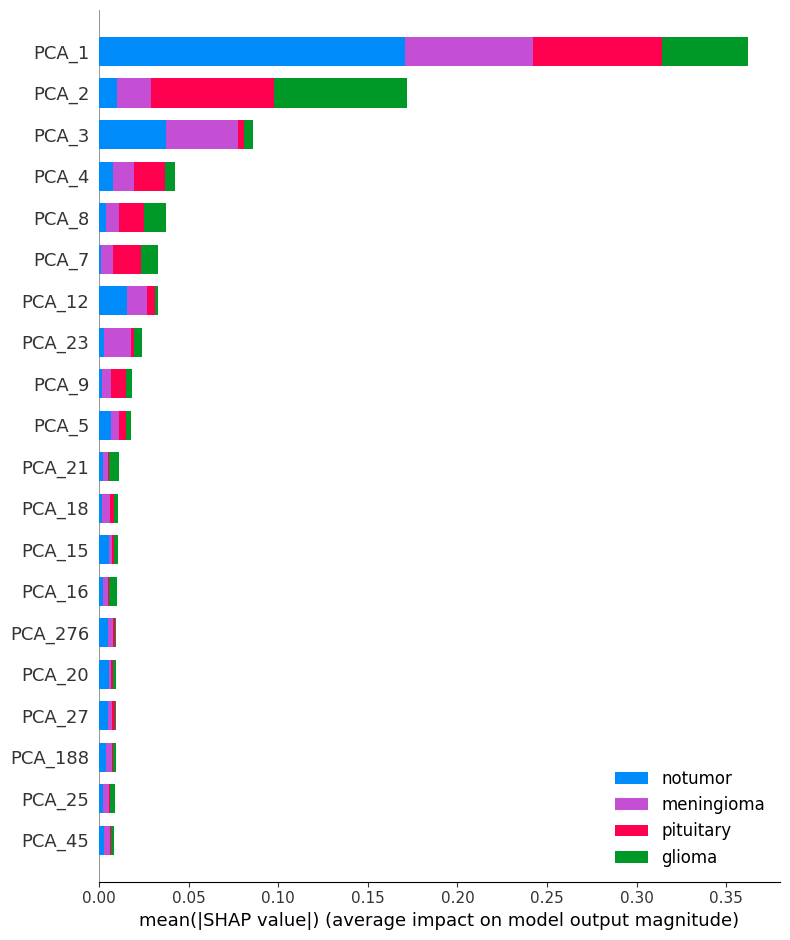


SHAP Explanation for Test Instance 0:


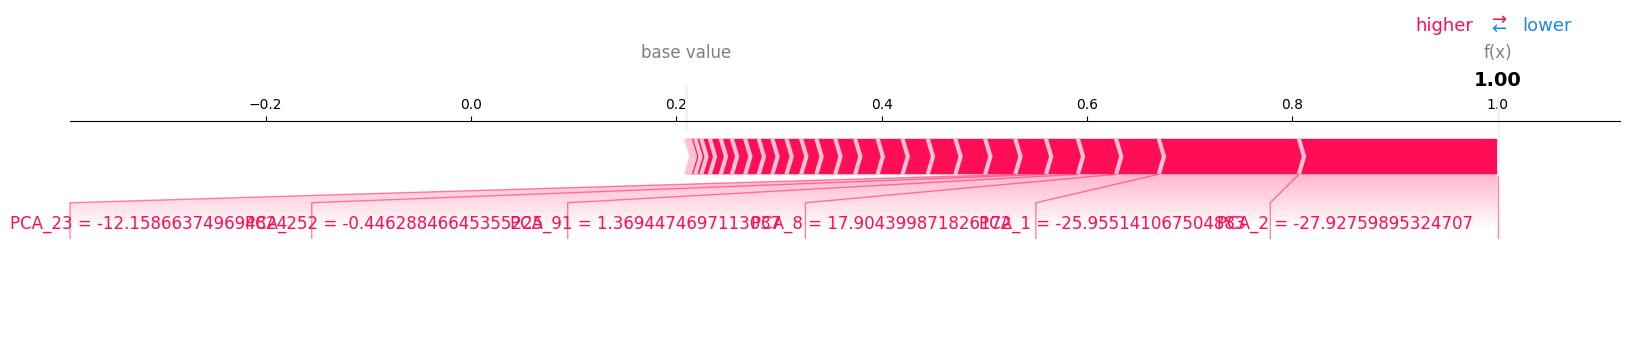

In [70]:
# SHAP Explanations (Local and Global Interpretability)
background_data = X_train_pca[np.random.choice(X_train_pca.shape[0], 100, replace=False)]
shap_explainer = shap.KernelExplainer(svm.predict_proba, background_data)
shap_values = shap_explainer.shap_values(X_test_pca[:50], nsamples=200)
print("\nSHAP Summary Plot (Global Feature Importance):")
shap.summary_plot(shap_values, X_test_pca[:50], feature_names=feature_names, class_names=class_names, plot_type="bar")
plt.show()
print("\nSHAP Explanation for Test Instance 0:")
shap.force_plot(shap_explainer.expected_value[0], shap_values[0][0], X_test_pca[0], feature_names=feature_names, matplotlib=True)
plt.show()

### Interpretation of SHAP Results

#### SHAP Summary Plot (Global Feature Importance)
- **Top Features**:
  - **PCA_1**: Highest importance, with significant contributions from notumor (blue), meningioma (purple), pituitary (red), and glioma (green), indicating a broad discriminative role.
  - **PCA_2**: High importance, dominated by glioma (green), suggesting it is critical for glioma classification.
  - **PCA_3**: Notable importance, with contributions from notumor (blue), meningioma (purple), and pituitary (red), playing a key role in these classes.
- **Class-Specific Insights**:
  - **Glioma (Green)**: Strongest in PCA_2, indicating it captures glioma-specific patterns.
  - **Pituitary (Red)**: Significant in PCA_1 and PCA_3, aiding pituitary tumor differentiation.
  - **Meningioma (Purple)**: Present in PCA_1 and PCA_3, contributing to meningioma classification.
  - **Notumor (Blue)**: Notable in PCA_1, reflecting its role in identifying non-tumor cases.
- **Lower Features**: PCA_4, PCA_8, PCA_7, and others have minimal impact, with contributions spread across classes.

### Key Insights
- Globally, PCA_1, PCA_2, and PCA_3 are the most influential features, with class-specific patterns (e.g., glioma in PCA_2, pituitary in PCA_1 and PCA_3).



Partial Dependence Plots for Top PCA Components:


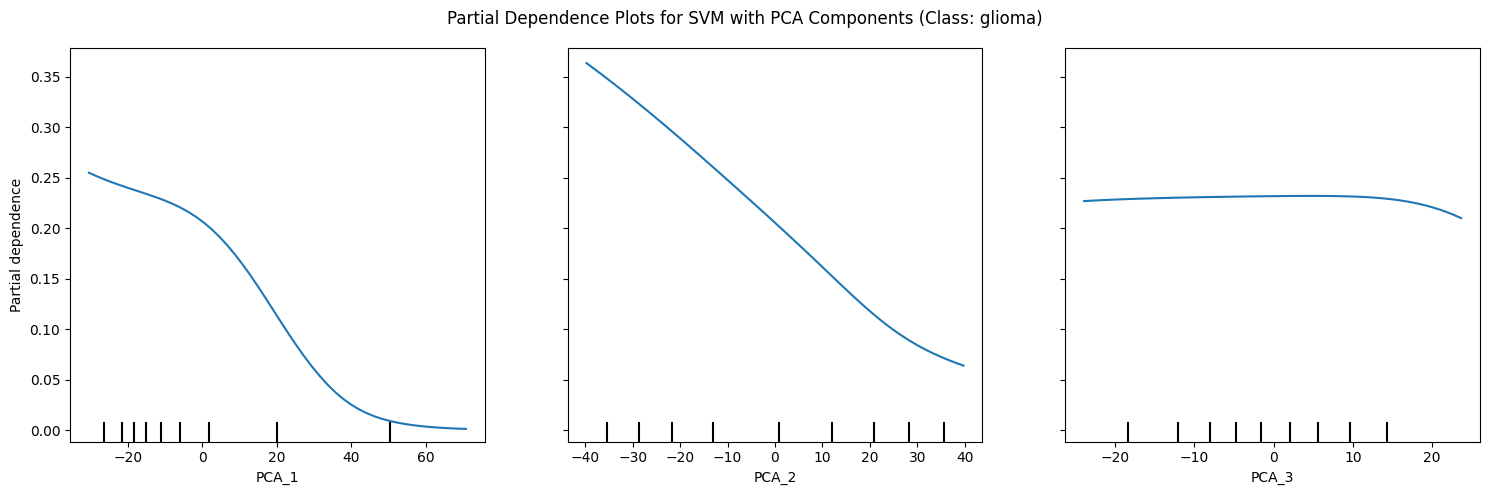

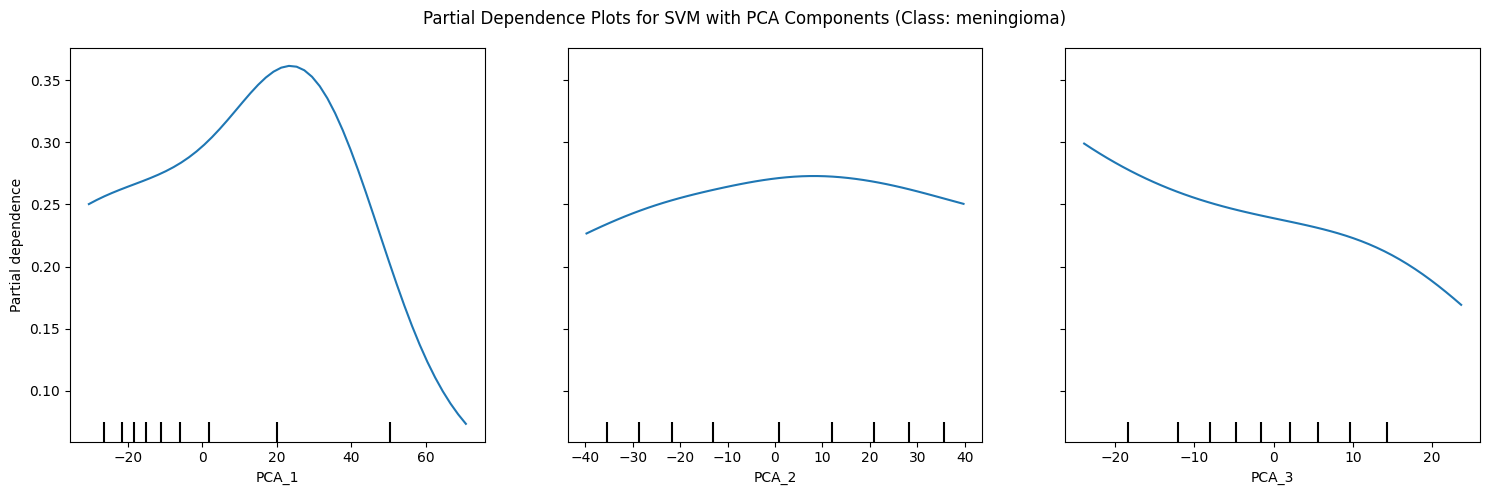

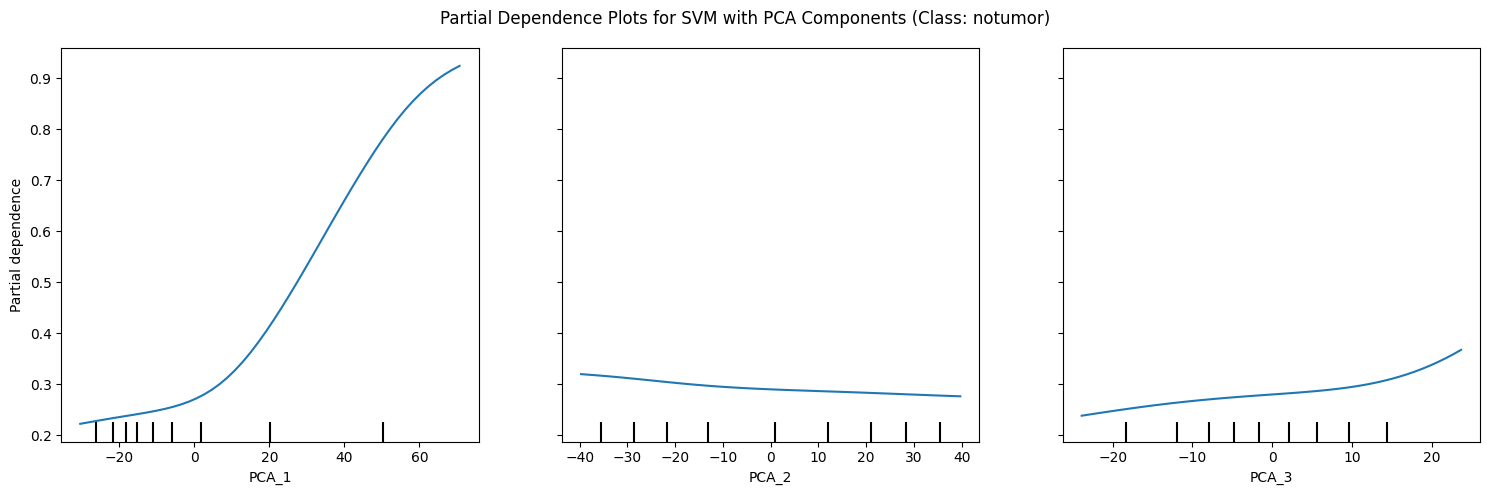

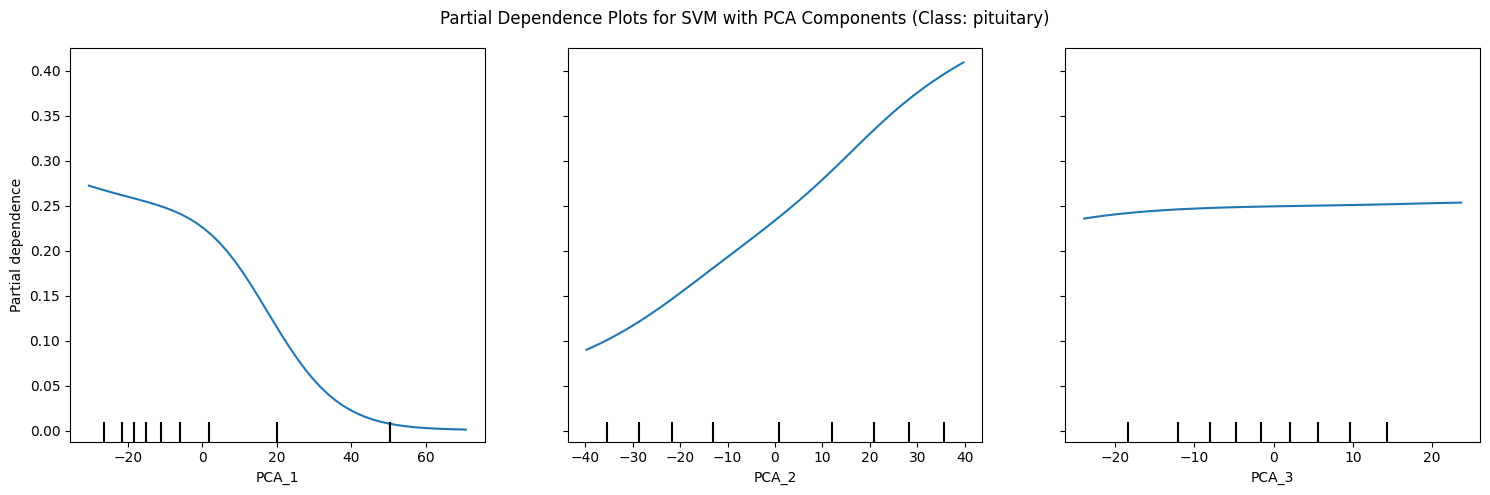

In [71]:
from sklearn.inspection import PartialDependenceDisplay
print("\nPartial Dependence Plots for Top PCA Components:")
features_to_plot = [0, 1, 2]  # Correspond to PCA_1, PCA_2, PCA_3
for class_idx, class_name in enumerate(class_names):
    fig, ax = plt.subplots(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        estimator=svm,
        X=X_train_pca,
        features=features_to_plot,
        feature_names=feature_names,
        target=class_idx,  # Specify the class index for multi-class
        grid_resolution=50,
        ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots for SVM with PCA Components (Class: {class_name})')
    plt.tight_layout()
    plt.show()

Interpretation of Partial Dependence Plots for SVM

Class: Glioma





PCA_1: Decreases from 0.25 to 0 as PCA_1 increases from -20 to 60. Low PCA_1 favors glioma.



PCA_2: Decreases from 0.25 to 0 as PCA_2 increases from -40 to 40, with low values supporting glioma.



PCA_3: Remains flat around 0.2 from -20 to 20, with minimal impact on glioma prediction.

Class: Meningioma





PCA_1: Increases from 0.15 to 0.35 as PCA_1 rises from -20 to 60, peaking around 40, then declines. Moderate to high PCA_1 favors meningioma.



PCA_2: Remains flat around 0.25 from -40 to 40, with minimal impact on meningioma prediction.



PCA_3: Decreases from 0.25 to 0.15 as PCA_3 increases from -20 to 20, with low values favoring meningioma.

Class: Notumor





PCA_1: Increases sharply from 0.2 to 0.9 as PCA_1 rises from -20 to 60. Higher PCA_1 strongly favors notumor.



PCA_2: Remains flat around 0.3 from -40 to 40, with minimal impact on notumor prediction.



PCA_3: Increases slightly from 0.2 to 0.4 as PCA_3 rises from -20 to 20, with higher values moderately favoring notumor.

Class: Pituitary





PCA_1: Decreases from 0.25 to 0.05 as PCA_1 increases from -20 to 60. Low PCA_1 favors pituitary.



PCA_2: Increases sharply from 0.1 to 0.4 as PCA_2 rises from -40 to 40. Higher PCA_2 strongly favors pituitary.



PCA_3: Remains flat around 0.2 from -20 to 20, with minimal impact on pituitary prediction.

Summary





PCA_1: High values strongly favor notumor, moderate to high values favor meningioma, low values favor glioma and pituitary.



PCA_2: High values strongly favor pituitary, low values favor glioma, with minimal impact on meningioma and notumor.



PCA_3: Higher values moderately favor notumor, low values favor meningioma, with minimal impact on glioma and pituitary.


Permutation Importance for PCA Components:


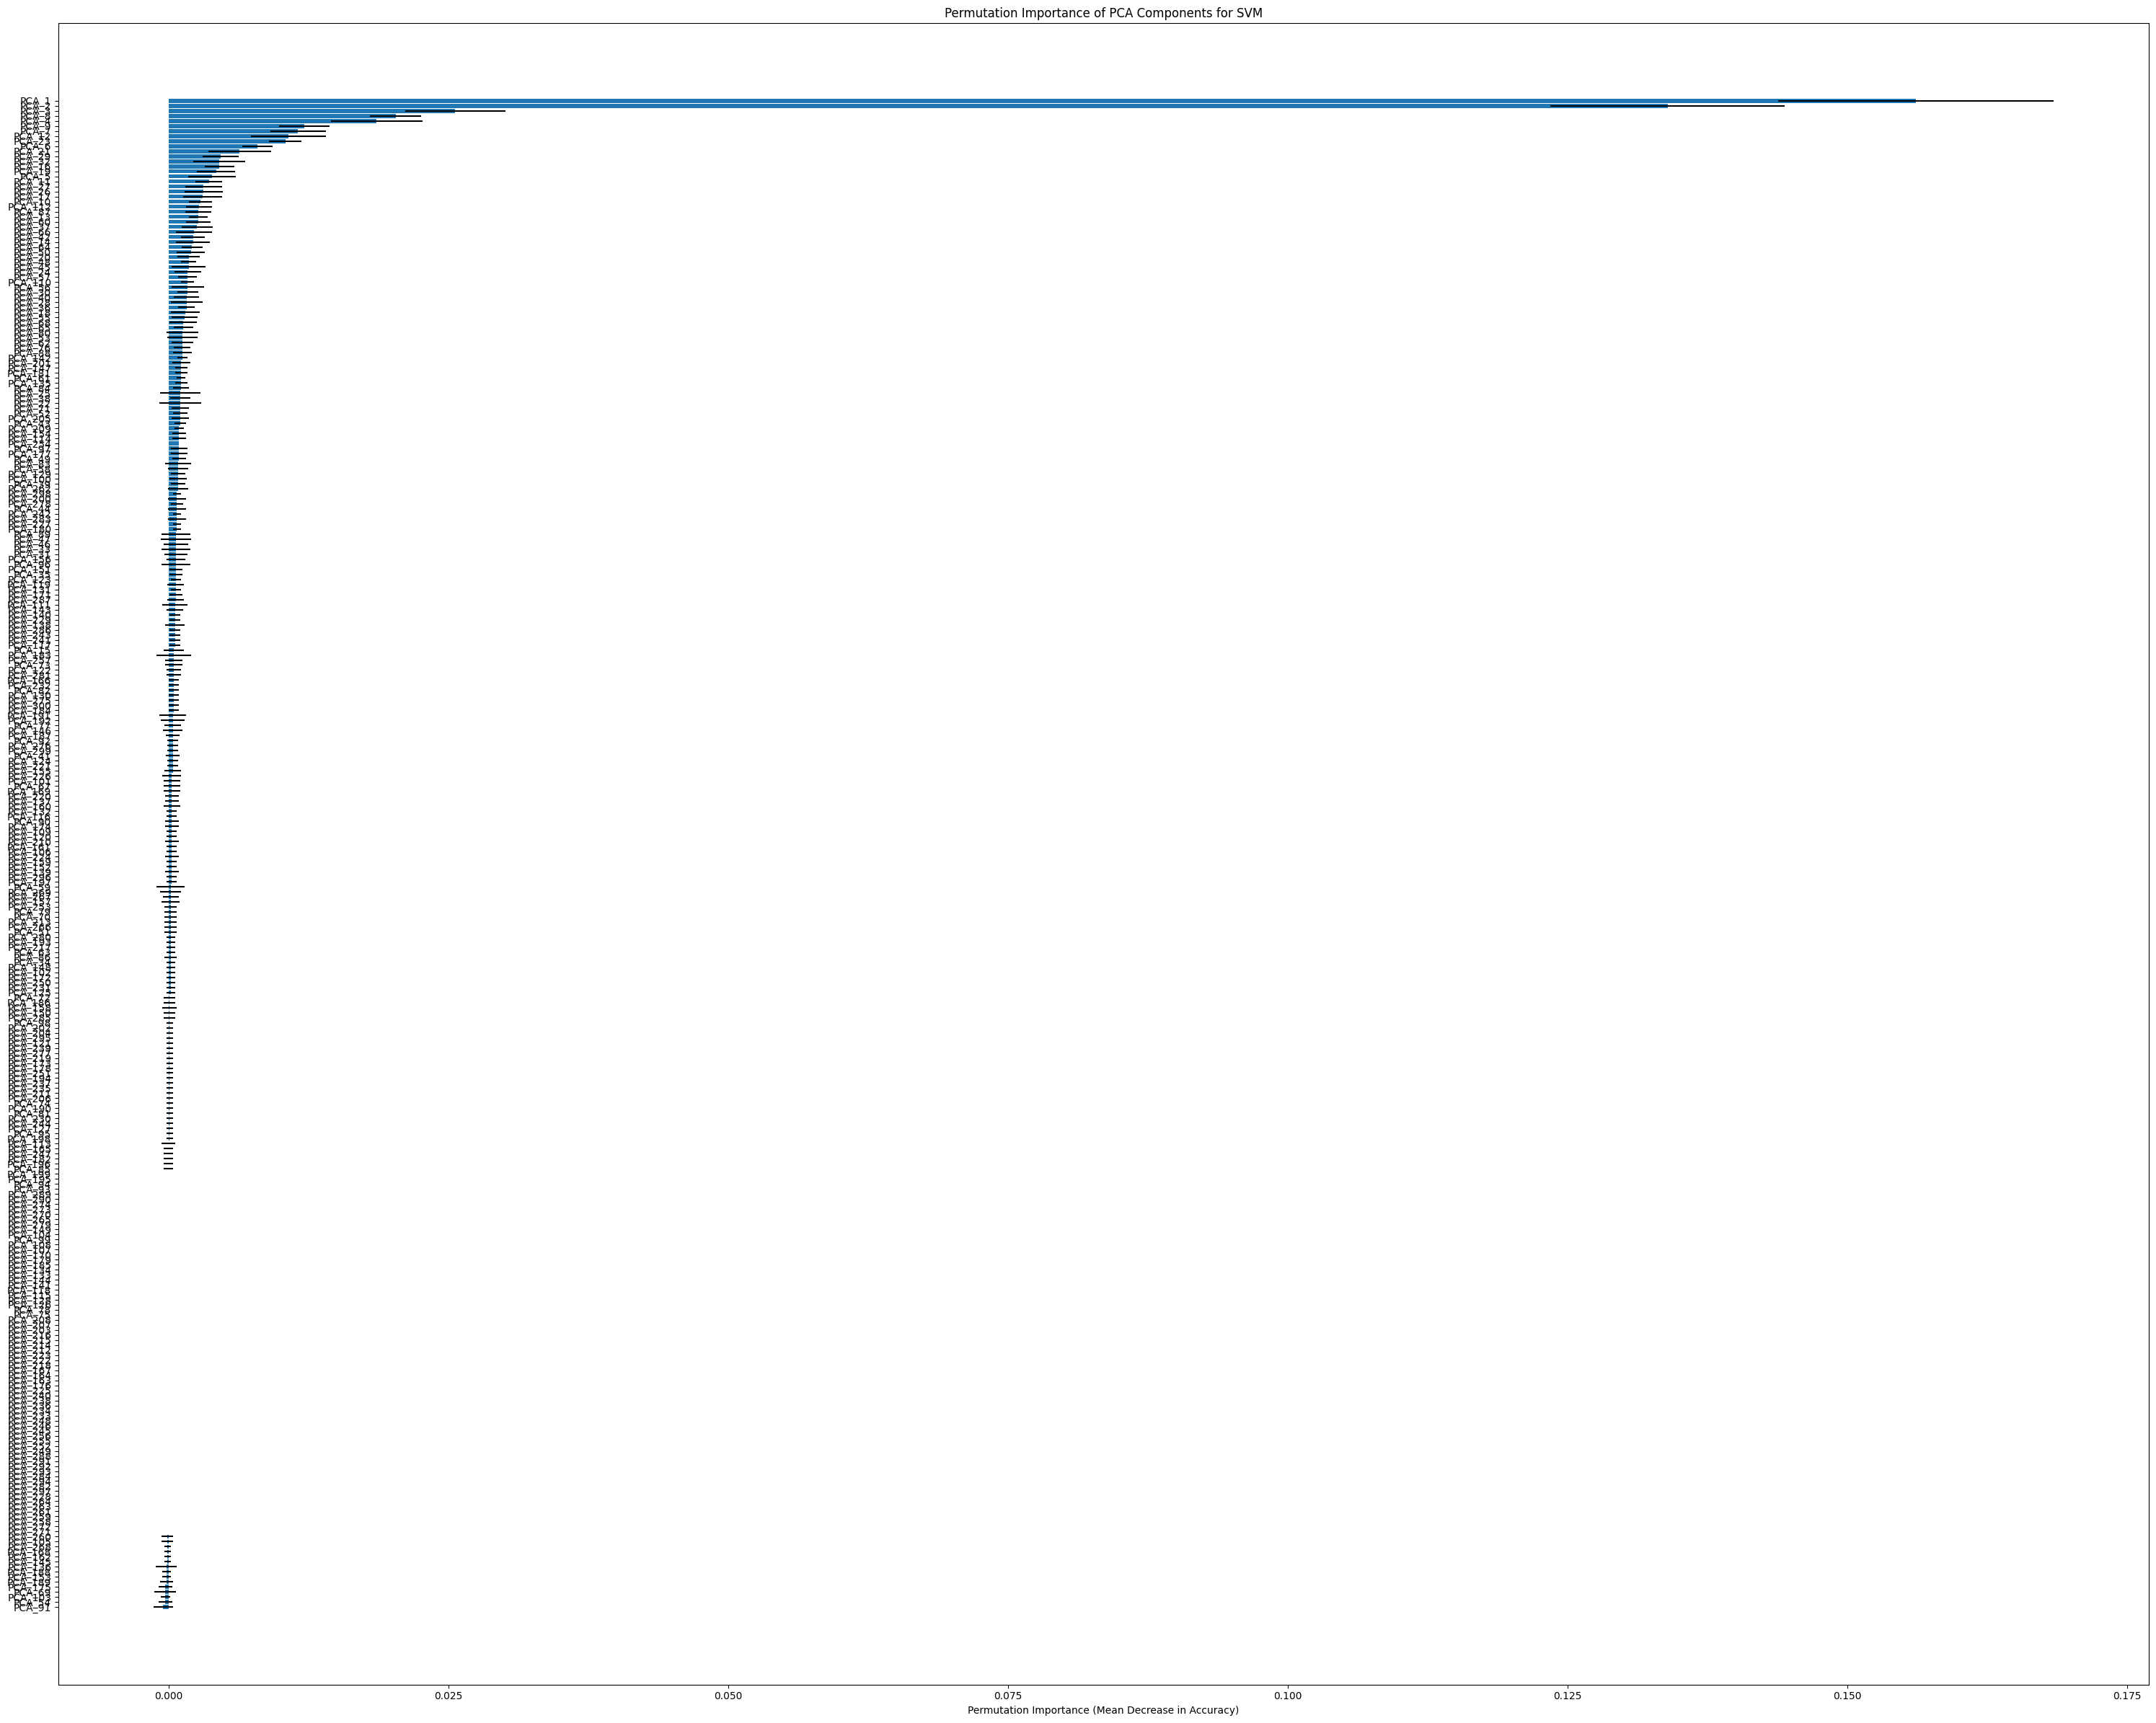

Permutation Importance Values:
PCA_1: 0.1562 ± 0.0123
PCA_2: 0.1340 ± 0.0105
PCA_3: 0.0256 ± 0.0045
PCA_8: 0.0203 ± 0.0023
PCA_4: 0.0186 ± 0.0041
PCA_9: 0.0121 ± 0.0023
PCA_7: 0.0116 ± 0.0025
PCA_12: 0.0107 ± 0.0034
PCA_23: 0.0104 ± 0.0015
PCA_6: 0.0080 ± 0.0014
PCA_21: 0.0064 ± 0.0028
PCA_29: 0.0046 ± 0.0016
PCA_32: 0.0046 ± 0.0023
PCA_16: 0.0046 ± 0.0013
PCA_19: 0.0043 ± 0.0017
PCA_5: 0.0039 ± 0.0021
PCA_11: 0.0036 ± 0.0012
PCA_27: 0.0031 ± 0.0016
PCA_26: 0.0031 ± 0.0017
PCA_17: 0.0030 ± 0.0017
PCA_10: 0.0028 ± 0.0010
PCA_112: 0.0028 ± 0.0012
PCA_87: 0.0027 ± 0.0012
PCA_13: 0.0027 ± 0.0008
PCA_60: 0.0027 ± 0.0011
PCA_37: 0.0026 ± 0.0014
PCA_66: 0.0023 ± 0.0016
PCA_42: 0.0022 ± 0.0010
PCA_14: 0.0022 ± 0.0015
PCA_64: 0.0021 ± 0.0009
PCA_50: 0.0020 ± 0.0012
PCA_20: 0.0018 ± 0.0010
PCA_48: 0.0018 ± 0.0007
PCA_45: 0.0018 ± 0.0015
PCA_24: 0.0017 ± 0.0012
PCA_57: 0.0017 ± 0.0008
PCA_110: 0.0017 ± 0.0006
PCA_56: 0.0017 ± 0.0015
PCA_30: 0.0017 ± 0.0009
PCA_40: 0.0016 ± 0.0011
PCA_28: 0.0016 ±

In [72]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
print("\nPermutation Importance for PCA Components:")
perm_importance = permutation_importance(svm, X_test_pca, y_test, n_repeats=10, random_state=42, n_jobs=-1)
# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()
# Plot permutation importance
plt.figure(figsize=(30, 24))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.title('Permutation Importance of PCA Components for SVM')
plt.tight_layout()
plt.show()
# Print permutation importance values
print("Permutation Importance Values:")
for i in sorted_idx[::-1]:  # Print in descending order
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

### Interpretation of Permutation Importance Values

- **Top Features**:
  - **PCA_1 (0.1562 ± 0.0123)**: Most important, significantly impacts performance, likely capturing primary MRI patterns.
  - **PCA_2 (0.1340 ± 0.0105)**: Second most important, key for classification, possibly distinguishing tumor types.
  - **PCA_3 (0.0256 ± 0.0045)**: Moderate importance, contributes to model performance.

- **Mid-Tier Features**:
  - **PCA_8 (0.0203 ± 0.0023)**, **PCA_4 (0.0186 ± 0.0041)**, **PCA_9 (0.0121 ± 0.0023)**, **PCA_7 (0.0116 ± 0.0025)**, **PCA_12 (0.0107 ± 0.0034)**, **PCA_23 (0.0104 ± 0.0015)**: These components have smaller but notable impacts, aiding differentiation.

- **Low-Impact Features**:
  - **PCA_6 to PCA_300 (0.0080 to 0.0000)**: Many components have minimal importance, with values decreasing progressively.
  - **PCA_91 to PCA_298 (0.0005 to 0.0000)**: Most higher-order components are negligible, contributing little to performance.

- **Negative Impact Features**:
  - **PCA_260 to PCA_175 (-0.0001 to -0.0003)**: Slight negative values indicate these features may introduce noise, slightly reducing performance when permuted.

- **Summary**:
  The SVM model relies primarily on PCA_1 and PCA_2 for accurate classification, with PCA_3 and a few mid-tier components (e.g., PCA_8, PCA_4) providing additional support. Higher-order components (e.g., PCA_91 onward) are largely irrelevant, while a few (e.g., PCA_260, PCA_175) may slightly detract from performance.